# SBP(수축기혈압) 

### X변수(기본)
- sex : 1(남자), 2(여자)
- age : 20세 부터 5세 단위
- ht : 5cm단위
- wt : 5kg 단위
- waist : 허리둘레 cm
- bmi 
- smoking : 1(피우지 않음), 2(피웠다끊음), 3(피우고있음)
- alcohol : 0(마시지않음), 1(마심)

In [33]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 한글 지원
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

## 1. 데이터 불러오기

In [3]:
df = pd.read_csv('C:/Users/sja95/OneDrive/바탕 화면/dataset/건강검진2017.csv', encoding = 'euc-KR')

df.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [4]:
df = df[['성별코드','연령대코드(5세단위)','신장(5Cm단위)','체중(5Kg단위)','허리둘레','흡연상태','음주여부','수축기혈압']]
df.columns = ['sex','age','ht','wt','waist','smoking','alcohol','sbp']

## 2. 데이터 전처리

### 1) 결측값 제거

In [5]:
df = df.dropna(axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999089 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999089 non-null  int64  
 1   age      999089 non-null  int64  
 2   ht       999089 non-null  int64  
 3   wt       999089 non-null  int64  
 4   waist    999089 non-null  float64
 5   smoking  999089 non-null  float64
 6   alcohol  999089 non-null  object 
 7   sbp      999089 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 68.6+ MB


### 2) bmi column 생성

In [6]:
df['bmi'] = df['wt'] / ((df['ht']/100)**2)
df = df.round(decimals=2)

### 3) alcohol : str -> float형으로 변환

In [7]:
df.loc[(df.alcohol=='Y'),'alcohol'] = 1.0
df.loc[(df.alcohol=='N'), 'alcohol'] = 0.0

df = df.astype(float)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999089 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999089 non-null  float64
 1   age      999089 non-null  float64
 2   ht       999089 non-null  float64
 3   wt       999089 non-null  float64
 4   waist    999089 non-null  float64
 5   smoking  999089 non-null  float64
 6   alcohol  999089 non-null  float64
 7   sbp      999089 non-null  float64
 8   bmi      999089 non-null  float64
dtypes: float64(9)
memory usage: 76.2 MB


### 4) 이상값 제거

- IQR = Q3 - Q1 
- Q1 -3 * IQR => lower
- Q3 + 3 * IQR => upper 로 설정
- lower보다 작거나 upper보다 큰 값을 이상값으로 간주하고 제거

- 변수마다 lower, upper 값을 확인하고 제거하는 과정을 거치면 다른 변수 lower/upper값에 영향을 줄 수 있음
- 따라서, 변수 각각의 lower, upper 값을 미리 모두 확인 후 각 값에 맞춰 범위 외의 값을 제거해줌.

#### (1) lower / upper 값 구하기

In [9]:
columns = ['ht','wt','bmi','waist']

for column in columns:
    
    print('=======', column, '=======')
    
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    IQR = q75 - q25
    
    lower = q25 - IQR*3
    upper = q75 + IQR*3
    
    print('lower :', lower)
    print('upper :', upper, '\n')
    


======= ht =======
lower : 110.0
upper : 215.0 

======= wt =======
lower : 10.0
upper : 115.0 

======= bmi =======
lower : 8.070000000000004
upper : 39.36 

======= waist =======
lower : 32.999999999999986
upper : 128.9 



#### (2) 이상값 제거 - df_tmp에 저장 / df : 원본데이터

In [10]:
# ht
df_tmp = df.drop(df.loc[(df['ht']>215.0)|(df['ht']<110.0)].index)

# wt
df_tmp = df.drop(df.loc[(df['wt']>115.0)|(df['wt']<10.0)].index)

# bmi
df_tmp = df.drop(df.loc[(df['bmi']>39.36)|(df['bmi']<8.07)].index)

# waist
df_tmp = df.drop(df.loc[(df['waist']>128.9)|(df['waist']<32.9)].index)

## 2. Scaling

- 표준화(Standardization)
- 정규화(Normalization)

### 1) 표준화 : df_s

In [11]:
scaler2 = StandardScaler()

x_ht = scaler2.fit_transform(df[['ht']])
x_wt = scaler2.fit_transform(df[['wt']])
x_bmi = scaler2.fit_transform(df[['bmi']])
x_waist = scaler2.fit_transform(df[['waist']])

df_s = df[['sex','age','smoking','alcohol', 'sbp']]
df_s['ht'] = x_ht
df_s['wt'] = x_wt
df_s['bmi'] = x_bmi
df_s['waist'] = x_waist

print(df_s.info())
df_s.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999089 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999089 non-null  float64
 1   age      999089 non-null  float64
 2   smoking  999089 non-null  float64
 3   alcohol  999089 non-null  float64
 4   sbp      999089 non-null  float64
 5   ht       999089 non-null  float64
 6   wt       999089 non-null  float64
 7   bmi      999089 non-null  float64
 8   waist    999089 non-null  float64
dtypes: float64(9)
memory usage: 108.5 MB
None


,sex,age,smoking,alcohol,sbp,ht,wt,bmi,waist
0,1.0,8.0,1.0,1.0,120.0,0.836785,0.936746,0.578814,0.740661
1,1.0,7.0,3.0,0.0,130.0,1.913750,1.336077,0.220547,0.656193
2,1.0,9.0,1.0,0.0,120.0,0.298303,0.936746,1.033756,0.825129
3,1.0,11.0,1.0,0.0,145.0,1.375267,1.336077,0.627151,0.825129
4,1.0,11.0,1.0,0.0,138.0,0.298303,-0.261248,-0.532952,-0.104020


### 2) 정규화 : df_n

In [12]:
scaler1 = MinMaxScaler()
x_ht = scaler1.fit_transform(df_tmp[['ht']])
x_wt = scaler1.fit_transform(df_tmp[['wt']])
x_bmi = scaler1.fit_transform(df_tmp[['bmi']])
x_waist = scaler1.fit_transform(df_tmp[['waist']])

df_n = df_tmp[['sex','age','smoking','alcohol', 'sbp']]
df_n['ht'] = x_ht
df_n['wt'] = x_wt
df_n['bmi'] = x_bmi
df_n['waist'] = x_waist

print(df_n.info())
df_n.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 998994 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998994 non-null  float64
 1   age      998994 non-null  float64
 2   smoking  998994 non-null  float64
 3   alcohol  998994 non-null  float64
 4   sbp      998994 non-null  float64
 5   ht       998994 non-null  float64
 6   wt       998994 non-null  float64
 7   bmi      998994 non-null  float64
 8   waist    998994 non-null  float64
dtypes: float64(9)
memory usage: 76.2 MB
None


,sex,age,smoking,alcohol,sbp,ht,wt,bmi,waist
0,1.0,8.0,1.0,1.0,120.0,0.666667,0.434783,0.405178,0.591398
1,1.0,7.0,3.0,0.0,130.0,0.833333,0.478261,0.367249,0.580645
2,1.0,9.0,1.0,0.0,120.0,0.583333,0.434783,0.453341,0.602151
3,1.0,11.0,1.0,0.0,145.0,0.750000,0.478261,0.410295,0.602151
4,1.0,11.0,1.0,0.0,138.0,0.583333,0.304348,0.287477,0.483871


# 3. Modeling 

## 1) Linear Regression_표준화

In [13]:
## 1. split

X = df_s[['sex','age','ht','wt','bmi','waist','smoking','alcohol']]
y = df_s['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((699362, 8), (299727, 8), (699362,), (299727,))

In [14]:
## 2. fit 

RA = LinearRegression()
RA.fit(X_train, y_train)

## 3. Predict

y_hat = RA.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  13.239892371936612


## 2) Linear Regression_정규화

In [15]:
## 1. split

X = df_n[['sex','age','ht','wt','bmi','waist','smoking','alcohol']]
y = df_n['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((699295, 8), (299699, 8), (699295,), (299699,))

In [16]:
## 2. fit 

RA = LinearRegression()
RA.fit(X_train, y_train)

## 3. Predict

y_hat = RA.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  13.133528264181477


## 3) DecisionTreeRegressor_원본

In [17]:
##1. split

X = df_tmp[['sex','age','ht','wt','bmi','waist','smoking','alcohol']]
y = df_tmp['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((699295, 8), (299699, 8), (699295,), (299699,))

In [18]:
## 2. fit

DTR = DecisionTreeRegressor()
DTR.fit(X_train, y_train)

## 3. Predict

y_hat = DTR.predict(X_test)

## 4. Root MSE

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  14.835874122936579


## 4) DecisionTreeRegressor_GridSearchCV

In [19]:
##1. split

X = df_tmp[['sex','age','ht','wt','bmi','waist','smoking','alcohol']]
y = df_tmp['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

## 2. hyperparameter

params = {
    'max_depth' : [2,4,8,16,32,64],
    'min_samples_split' : [2,4,8,16,24]
}

## 3. model define & fit

DTR = DecisionTreeRegressor(random_state = 2045)
grid_cv = GridSearchCV(DTR, param_grid = params, scoring = 'accuracy',cv = 5, verbose=1)
grid_cv.fit(X_train, y_train)

## 4. 학습 평가

print(grid_cv.best_estimator_)
best_grid = grid_cv.best_estimator_

## 5. Predict

y_hat = best_grid.predict(X_test)

## 6. Prediction Estimate

rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print('rmse :', rmse)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
DecisionTreeRegressor(max_depth=2, random_state=2045)
rmse : 13.60123368686815


<AxesSubplot:title={'center':'Feature Importance'}>

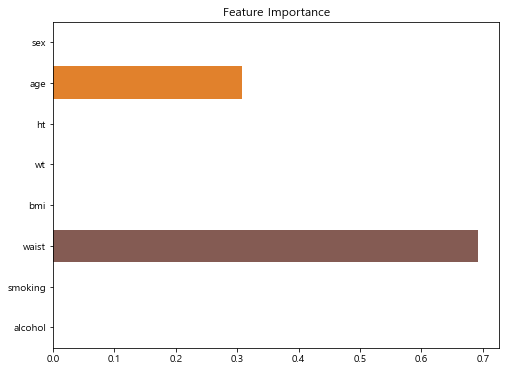

In [20]:
## feature Importance

fi = best_grid.feature_importances_
fiS = pd.Series(fi, index = X_train.columns)

plt.figure(figsize = (8,6))
plt.title('Feature Importance')
sns.barplot(x = fiS, y = fiS.index)

##  5) RandomForest

Wall time: 4min 4s


<AxesSubplot:>

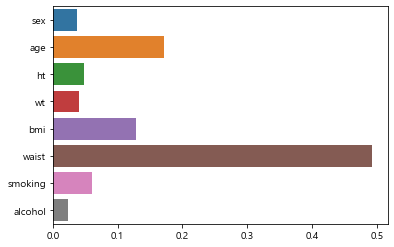

In [24]:
%%time
##1. split

X = df_tmp[['sex','age','ht','wt','bmi','waist','smoking','alcohol']]
y = df_tmp['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

## 2. model define & fit

rf = RandomForestRegressor(random_state = 2045, n_estimators = 200) # n_estimators : 생성할 tree 개수

rf.fit(X_train, y_train)

## 3. Feature Importance

feature_series = pd.Series(data = rf.feature_importances_, index = X_train.columns)
sns.barplot(x= feature_series, y=feature_series.index)


In [25]:
## 4. Predict

y_hat_rf = rf.predict(X_test)

## 5. Prediction Estimate

rmse = np.sqrt(mean_squared_error(y_test, y_hat_rf))
print('rmse :', rmse)

rmse : 13.89550765086492


## 6) RandomForest_hyperparameter

In [34]:
%%time

## 1. split


X = df_tmp[['sex','age','ht','wt','bmi','waist','smoking','alcohol']]
y = df_tmp['sbp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

## 2. model define

tmp = 100

for i in range(100, 401, 100):
    for j in range(2, 5, 1):
        for k in range(2, 5, 1):
            rf = RandomForestRegressor(random_state = 2045, n_estimators = i, max_features = j, max_depth = k)
            neg_mse_scores = cross_val_score(rf, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
            rmse_scores = np.sqrt(-1*neg_mse_scores)
            avg_rmse = np.mean(rmse_scores)
            print('5교차 검증 평균 RMSE : {0:.3f}'.format(avg_rmse))
            if avg_rmse < tmp :
                tmp = avg_rmse
                best_model = [i, j, k]
                
print('best_model : ', best_model)



5교차 검증 평균 RMSE : 13.576
5교차 검증 평균 RMSE : 13.402
5교차 검증 평균 RMSE : 13.296
5교차 검증 평균 RMSE : 13.509
5교차 검증 평균 RMSE : 13.346
5교차 검증 평균 RMSE : 13.256
5교차 검증 평균 RMSE : 13.491
5교차 검증 평균 RMSE : 13.326
5교차 검증 평균 RMSE : 13.234
5교차 검증 평균 RMSE : 13.578
5교차 검증 평균 RMSE : 13.392
5교차 검증 평균 RMSE : 13.293
5교차 검증 평균 RMSE : 13.511
5교차 검증 평균 RMSE : 13.345
5교차 검증 평균 RMSE : 13.256
5교차 검증 평균 RMSE : 13.488
5교차 검증 평균 RMSE : 13.323
5교차 검증 평균 RMSE : 13.234
5교차 검증 평균 RMSE : 13.580
5교차 검증 평균 RMSE : 13.400
5교차 검증 평균 RMSE : 13.298
5교차 검증 평균 RMSE : 13.514
5교차 검증 평균 RMSE : 13.346
5교차 검증 평균 RMSE : 13.255
5교차 검증 평균 RMSE : 13.489
5교차 검증 평균 RMSE : 13.323
5교차 검증 평균 RMSE : 13.233
5교차 검증 평균 RMSE : 13.580
5교차 검증 평균 RMSE : 13.405
5교차 검증 평균 RMSE : 13.299
5교차 검증 평균 RMSE : 13.511
5교차 검증 평균 RMSE : 13.345
5교차 검증 평균 RMSE : 13.252
5교차 검증 평균 RMSE : 13.494
5교차 검증 평균 RMSE : 13.324
5교차 검증 평균 RMSE : 13.234
best_model :  [300, 4, 4]
Wall time: 1h 47min 29s
